# Bedrock Classification in the Larder Lake Area (North Eastern Ontario)

This exercise was inspired by two sources:
- Medium posts from Jack Maughan (https://medium.com/@jackmaughan_50251)
- Two Peer-reviewed journal articles:
    - Hood et al. 2019 (https://doi.org/10.1016/j.acags.2019.100001)
    - Cracknell & Reading 2014 (https://doi.org/10.1016/j.cageo.2013.10.008)

The workflow was altered from Maughan's Mineral Prediction Mapping work that he has shared online (https://github.com/tunanottechnical/Jupyter-Workings/blob/master/Mineral%20Prediction%20Map%20with%20Machine%20Learning.ipynb).

## Viewing and Preparing Data in QGIS

QGIS is utilized in this process because it is open source software.  For more information, visit the [QGIS Website](https://www.qgis.org/en/site/index.html)
>NOTE: Version 3.20.3 is used in this exercise

### Adding imagery basemaps to provide spatial context

[Including satellite imagery](https://planet.qgis.org/planet/tag/world%20imagery/) as a basemap layer in QGIS can be accomplished by copying the following code into the python terminal:
`qgis.utils.iface.addRasterLayer("http://server.arcgisonline.com/arcgis/rest/services/ESRI_Imagery_World_2D/MapServer?f=json&pretty=true","raster")`

### Area of Interest (AOI) in Northeastern Ontario

Before looking at the area of interest in detail, we can get a sense of the spatial context with satellite imagery and several other illustrative datasets (i.e., cities, current and past producing mines, AOI around Larder Lake).
> Note: The white rectangle is the AOI for this exercise.  I did not include provincial borders, Rouyn-Noranda is in Quebec.

![AOI_Northeastern_Ontario](Images/AOI_BL.png)

A closer look at the AOI shows a heavily wooded area, with three historic mines in the area.  Directly west of the AOI is Kirkland Lake, where there is one currently operating mine (yellow circle).

![AOI_Larder_Lake](Images/AOI_BL_zoom.png)

### Datasets Used by Hood et al. 2019

Hood et al. (2019) utilized a number of datasets in the classification of bedrock, including:
- Historic Geological Maps
- Digital Terrain Model (DTM)
- Magnetic Geophysics (ASVI, RTP, RTP 1VD, RTP 2VD)
- Radiometric Geophysics (ThConc, UConc, KConc, Dose)
- Hyperspectral Remote Sensing [ASTER] (AlOH, Ferric Oxide content, Ferrous iron index, FeOH content, MgOH content, Kaolin)

I was only able to find three equivalent datasets for this exercise, including:
- Historic Geological Maps
- Digital Elevation Model (DEM)
- Magnetic Geophysics (RTP, RTP 1VD, RTP 2VD)

This will be a large limitation in the model output.  The radiometric data would be very helpful in identifying felsic vs. mafic outcrops, but I could not find a suitable dataset over this AOI.  The hyperspectral remote sensing imagery would also add very useful parameters in the bedrock classification, but I could not figure out how to download the data.

### Visualizing All Datasets

Importing all datasets into QGIS provides a quick assessment of the spatial extent this exercise must be limited to.  The three geophysical datasets (Magnetic RTP, 1VD, and 2VD), along with the geological map and the DEM illustrate that the DEM will roughly determine the AOI of this exercise.

The geological maps used in this exercise are digitized versions produced by the Ontario Geological Survey in the 1940's by J.A. Thomson (ARM50A, ARM50B, and ARM50C).  These maps display both outcrop geological maps, and the overall inferred geology of the study areas.  Although these maps are old, they are held in high regard for the level of detail provided.

![QGIS_AllData](Images/BL_ML_Data.png)

### Define an AOI

After reviewing all datasets, an AOI must be defined, to which all data will be clipped.  This will provide a consistent raster shape across all datasets.

Care must be taken to ensure the AOI is perfectly square, otherwise the clipping process for the rasters will produce streaks of "no value" in the datasets (e.g., see image below where the clipped version of Mag RTP is overlaying the unclipped version, and there are black lines as a result of a poorly defined AOI).

![Clipping with poor AOI](Images/AOI_Issues.png)

Creating perfect AOIs can be accomplished by defining the vertices in a wkt (well known text) format within a csv.  An AOI in this example would contain this exact text in a cell of a csv file:
>`POLYGON((607950 5337950, 607950 5328300, 588000 5328300, 588000 5337950, 607950 5337950))`

The Data Source Manager can then be used to add the text delimited file with your AOI.

### Rasterize Vector Files

In this exersize, the only vector file used is the geological map.  The machine learning process requires that all files are represented by rasters with matching size and resolution.  The limiting factor at this stage is the geophysical data, which has a resolution of 11.2 x 11.2 metre pixels.  In comparison, the DEM data has a resolution of 2 x 2 metre pixels.  Ideally we would want to use only high resolution datasets (e.g., 2x2 metre pixels), but we will convert everything into 10 x 10 metre pixels for this exercise.

The rasterize geoprocessing tool in QGIS is found under the Raster tab, in the conversion section.  I have added a new numerical column in the geology vector file that assigns a number value to each geological unit.  The rasterize tool will use this column as the input for each 10 x 10 pixel (referred to as the "value to burn").  The output should look like this:

![Rasterized Outcrops](Images/BL_ML_RasterizedOutcrops.png)

### Standardize Raster Resolution

As previously mentioned, all rasters must be the same resolution and size, commonly referred to as shape.  The shape of the rasterized geology is 1995 x 965.  The DEM (9975 x 4825) and geophysics (1778 x 860) datasets both must be resized.  The warp geoprocessing tool found under the Raster/Projections tab will be utilized for this task.  The projections wont actually be altered using this tool, rather we will change the pixel size using the nearest neighbor algorithm to provide a consistent dataset for the machine learning process (see picture below).

![BL_warp](Images/BL_ML_Warp.png)

# Using Python

### Python (3.7) Required Packages

- Numpy
- Sklearn (abbr. for scikit-learn)
- Skimage (abbr. for scikit-image)
- Matplotlib
- Pandas
- Rasterio

This exercise was completed with python, version displayed below

In [1]:
!python --version

Python 3.7.10


### Anaconda

Using Anaconda is recommended for a couple of reasons, namely:

- easy package downloading
- download packages not written in python
- ability to create multiple environments to accommodate odd dependency senarios

> Note: downloading the raterio package was problematic - make sure you connect to the "conda-forge" channel.  Could not resolve issues with python 3.8, created a new environment in anaconda with python 3.7 to get around this problem.

### Image processing

In [2]:
#Importing the python packages

import pandas as pd
import numpy as np
from skimage import io   #called scikit-image in anaconda

In [4]:
#Load the images prepared in QGIS
mag_RTP = io.imread('/Users/dmeek/Desktop/BL_Python_Classification/Model_Inputs/Clipped_MAG_RTP_BL_10p.tif')
mag_1VD = io.imread('/Users/dmeek/Desktop/BL_Python_Classification/Model_Inputs/Clipped_MAG_RTP_1VD_BL_10p.tif')
mag_2VD = io.imread('/Users/dmeek/Desktop/BL_Python_Classification/Model_Inputs/Clipped_MAG_RTP_2VD_BL_10p.tif')
geo = io.imread('/Users/dmeek/Desktop/BL_Python_Classification/Model_Inputs/Rasterized_ARM50_All_Outcrops_10p.tif')
dem = io.imread('/Users/dmeek/Desktop/BL_Python_Classification/Model_Inputs/Clipped_Merged_BL_COOP2016_DEM_10p.tif')

#Checking the image datatypes 
print(type(mag_RTP))
print(type(mag_1VD))
print(type(mag_2VD))
print(type(geo))
print(type(dem))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


We have loaded all 5 images as numpy arrays using the python package 'scikit-image' (referred to as skimage here; I think this is just a convention thing from the examples I have seen). Numpy array is the input data format which is required by the machine learning python package 'scikit-learn' so this is a good start. However, when importing images as numpy arrays it is important to make sure that they have the same dimensions (or shape). We attempted to address this in QGIS using the Raster warp tool, but to double check we use the following code:

In [5]:
#Analysing the shape of each numpy array,
print('Magnetic RTP shape is',mag_RTP.shape)
print('Magnetic 1VD shape is',mag_1VD.shape)
print('Magnetic 2VD shape is',mag_2VD.shape)
print('Geology shape is',geo.shape)
print('DEM shape is',dem.shape)

Magnetic RTP shape is (965, 1994, 3)
Magnetic 1VD shape is (965, 1994, 3)
Magnetic 2VD shape is (965, 1994, 3)
Geology shape is (965, 1995)
DEM shape is (965, 1995)


This has uncovered two issues with our datasets.  The first is that the magnetics datasets are three dimensional arrays.  The second issue is that the shape of the magnetics datasets are slightly different, displaying a 965x1994 matrix as opposed to a 965x1995 matrix as is the case with geology and DEM data.

The three dimensional nature of the magnetics datasets is expected, because these were RGB images.  This means that there are 3 965x1994 matrices in the numpy arrays, one for each color (i.e., Red, Green, Blue). Looking at the raw data provides a better sense of this:

In [6]:
print(mag_RTP[0:3])

[[[127  84   0]
  [127  63   0]
  [127  63   0]
  ...
  [219 219   0]
  [219 219   0]
  [215 215   0]]

 [[ 90 127   0]
  [127 105   0]
  [127  84   0]
  ...
  [219 219   0]
  [219 219   0]
  [219 219   0]]

 [[  0 127   0]
  [ 17 127   0]
  [ 54 127   0]
  ...
  [223 223   0]
  [223 223   0]
  [223 201   0]]]


The first pixel of the image is [127,84,0], while the last pixel of the data printed is [223,201,0].  To convert these images into a two dimenional array we need to reimport them into this notebook as greyscale images.  Scikit-Image contains an optional boolean paramter 'as_gray' that will convert color images into 64-bit grey-scale float values (a value between 0 - 1).

In [7]:
#Reimporting the images using the as_gray parameter to generate two dimensional numpy arrays
mag_RTP = io.imread('/Users/dmeek/Desktop/BL_Python_Classification/Model_Inputs/Clipped_MAG_RTP_BL_10p.tif', as_gray = True)
mag_1VD = io.imread('/Users/dmeek/Desktop/BL_Python_Classification/Model_Inputs/Clipped_MAG_RTP_1VD_BL_10p.tif', as_gray = True)
mag_2VD = io.imread('/Users/dmeek/Desktop/BL_Python_Classification/Model_Inputs/Clipped_MAG_RTP_2VD_BL_10p.tif', as_gray = True)

#Analysing the new array shapes
print('The new mag_RTP shape is',mag_RTP.shape)
print('The new mag_1VD shape is',mag_1VD.shape)
print('The new mag_2VD shape is',mag_2VD.shape)

The new mag_RTP shape is (965, 1994)
The new mag_1VD shape is (965, 1994)
The new mag_2VD shape is (965, 1994)


In [8]:
print(mag_RTP.round(4))

[[0.3415 0.2826 0.2826 ... 0.7969 0.7969 0.7823]
 [0.4313 0.4004 0.3415 ... 0.7969 0.7969 0.7969]
 [0.3563 0.3705 0.4013 ... 0.8115 0.8115 0.7497]
 ...
 [0.1192 0.1192 0.1192 ... 0.4822 0.4822 0.4822]
 [0.1192 0.1192 0.1192 ... 0.4822 0.4822 0.4822]
 [0.1192 0.1192 0.1192 ... 0.4822 0.4822 0.4822]]


Now the first pixel of the image is 0.3415 (rather than [127,84,0]).

With the first issue addressed, the slightly different shapes must be fixed.  Considering that the same AOI was used to generate each clipped image, why these three datasets are missing a column of pixels is unclear (perhaps this was related to the warp process).  As a quick fix, we will trim the last column from the geo and dem arrays to produce arrays of the same size (965x1994). To do this, we will use the row and column indexes to specify that we want all data except for the last column.

In [9]:
#Reshape the geo and dem data
geo = geo[:,:-1]
dem = dem[:,:-1]

#Analyze the new array shapes
print('The new geo shape is',geo.shape)
print('The new dem shape is',dem.shape)

The new geo shape is (965, 1994)
The new dem shape is (965, 1994)


### Formatting Data

All arrays are now the same shape, 965x1994.  However, scikit-learn requires one dimensional numpy arrays.  To address this next issue, the numpy 'flatten' module will be used.  In essence, this takes each row of the matrix and places it after the preceeding row.

In [10]:
#For more details about flattening a matrix, uncomment the code below
#help(np.ndarray.flatten)

In [11]:
#Flattening the arrays to become a single 1D numpy array or vector list of pixel values
mag_RTP = mag_RTP.flatten()
mag_1VD = mag_1VD.flatten()
mag_2VD = mag_2VD.flatten()
geo = geo.flatten()
dem = dem.flatten()

#Checking the shape or array length lines up for all arrays
print(mag_RTP.shape)
print(mag_1VD.shape)
print(mag_2VD.shape)
print(geo.shape)
print(dem.shape)

(1924210,)
(1924210,)
(1924210,)
(1924210,)
(1924210,)


The image pixel values have now been converted into a single dimensional array of 1,924,210 values, which when lined up and transposed can be represented as a data table. With the help of python package 'Pandas', this is our next step.

In [12]:
#Creating a pandas dataframe from all the arrays. T is used to transpose the dataframe
df = pd.DataFrame(data=[mag_RTP, mag_1VD, mag_2VD, geo, dem]).T

#Assigning the column names to each feature
df.columns=['mag_RTP', 'mag_1VD', 'mag_2VD', 'geo', 'dem']

#Checking to see if it worked
print(df.head(5))

    mag_RTP   mag_1VD   mag_2VD  geo         dem
0  0.341495  0.035909  0.184600  0.0  318.619995
1  0.282579  0.035909  0.209849  0.0  317.970001
2  0.282579  0.035909  0.235098  0.0  316.220001
3  0.251719  0.035909  0.268764  0.0  317.670013
4  0.251719  0.035909  0.313652  0.0  317.140015


Here we can see the first 5 lines of the dataframe (or data table). The magnetics datasets are represented by numeric pixel values between 0-1, the geo column is represented by integer values corresponding to geological units, and the dem column is represented by numeric values corresponding to elevation in metres.  The magnetics datasets and dem should be numeric (or float) values, but we want the geo column to be categorical.  To do this we change the data type to be 'str' (string).

In [13]:
#Assigning the correct data types to each feature
df.mag_RTP=df['mag_RTP'].astype(float)
df.mag_1VD=df['mag_1VD'].astype(float)
df.mag_2VD=df['mag_2VD'].astype(float)
df.geo=df['geo'].astype(str)
df.dem=df['dem'].astype(float)

print(df.dtypes)

mag_RTP    float64
mag_1VD    float64
mag_2VD    float64
geo         object
dem        float64
dtype: object


### Building Model

Next we want to start creating our model. For this we only want the areas where we know the geology has been classified (where geo != 0.0), so we need to drop all pixels where geo == 0.0, creating a new subset dataframe.

In [14]:
#Creating a subset dataframe where the geology has been classified
df_model=df[df['geo']!=('0.0')].copy()

#Checking our new data
print(df_model.describe())

             mag_RTP        mag_1VD        mag_2VD            dem
count  413905.000000  413905.000000  413905.000000  413905.000000
mean        0.366192       0.407190       0.437610     325.610499
std         0.217094       0.219588       0.210777      20.787655
min         0.035909       0.035909       0.035909     270.519989
25%         0.189167       0.212500       0.251931     313.470001
50%         0.317221       0.416044       0.433421     323.279999
75%         0.549596       0.608378       0.614402     334.600006
max         0.913345       0.927900       0.927900     431.010010


In [15]:
#Create an index on the Geology column to investigate classification frequencies
geo_idx=pd.Index(df_model['geo'])

In [16]:
#Create a data series to use for a quick visual plot
geo_count=geo_idx.value_counts()

print(geo_count)

6.0     100658
23.0     56367
15.0     48212
13.0     40614
5.0      33185
1.0      26710
18.0     21280
10.0     15445
16.0     13314
19.0      9253
14.0      8303
4.0       7793
7.0       7626
9.0       5280
24.0      4360
11.0      4215
22.0      3510
20.0      2816
21.0      2133
8.0       1307
17.0       724
3.0        517
2.0        154
12.0       129
Name: geo, dtype: int64


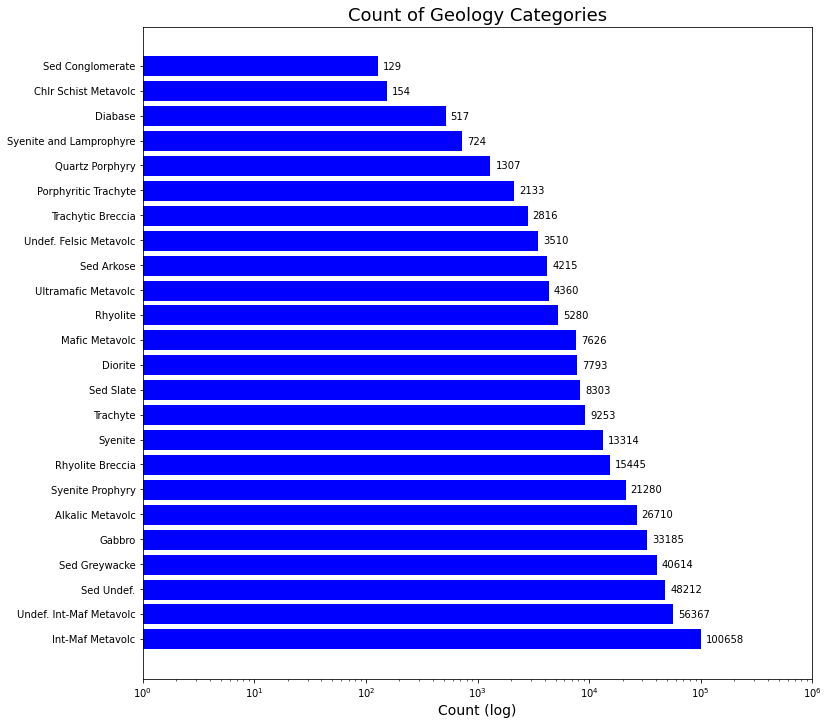

In [18]:
import matplotlib.pyplot as plt

geocnt_x = ["Int-Maf Metavolc", "Undef. Int-Maf Metavolc", "Sed Undef.", "Sed Greywacke", "Gabbro",
             "Alkalic Metavolc", "Syenite Prophyry", "Rhyolite Breccia","Syenite","Trachyte", "Sed Slate",
           "Diorite", "Mafic Metavolc", "Rhyolite", "Ultramafic Metavolc", "Sed Arkose", "Undef. Felsic Metavolc",
           "Trachytic Breccia", "Porphyritic Trachyte", "Quartz Porphyry", "Syenite and Lamprophyre",
           "Diabase", "Chlr Schist Metavolc", "Sed Conglomerate"]
geocnt_y = [100658, 56367, 48212, 40614, 33185, 26710, 21280, 15445, 13314, 9253, 8303, 7793, 7626, 5280,
           4360, 4215, 3510, 2816, 2133, 1307, 724, 517, 154, 129]

fig, ax = plt.subplots(figsize=(12,12))
width = 0.8 # the width of the bars 
ind = np.arange(len(geocnt_y))  # the x locations for the groups
ax.barh(ind, geocnt_y, width, color="blue")
ax.set_yticks(ind+width/40)
ax.set_yticklabels(geocnt_x, minor=False)
ax.set_xlim(1, 1000000) # expand xlim to make labels easier to read
ax.set_xscale('log')
plt.title('Count of Geology Categories', fontsize=18)
plt.xlabel('Count (log)', fontsize=14)

rects = ax.patches

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2  
    space = 5     # Number of points between bar and label
    ha = 'left'   # Vertical alignment

    # Use X value as label and format number
    label = "{:.0f}".format(x_value)

    # Create annotation
    plt.annotate(label,                     # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(space, 0),          # Horizontally shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                va='center',                # Vertically center label
                ha=ha)                      # Horizontally align label

With a plot of our model dataset, the discrepancy between the number of categories is strikingly clear.  Some of these classes can be cleaned up (e.g., Chlorite Schist Metavolcanics & Int. - Mafic Metavolcanics, Conglomerate & Undefined Sediments, Diabase & Gabbro, Undef Int. - Mafic Metavolcanics & Int. - Mafic Metavolcanics, etc.)

There is still a large discrepancy, 2 orders of magnitude, between the new minority class (quartz porphyry; n=1307) and majority class (intermediate to mafic metavolcanics; n=157179).  Methods to properly account for these over and under representations is outlined nicely by Hood et al. (2019); in which they use multiple techniques to produce a balanced train-test dataset.  These should be investigated further after the ML process has been verified.

To produce a test/train dataset, each geological category was split into seperate dataframes (and grouped when required or very similar classifications).  After this, 1000 records from each category were randomly selected.  The selection of n=1000 was based on the fact that all existing groups contain at least 1000 records, and this produced a reasonably sized model dataset.

In [19]:
#create seperate dataframes where geology categories are seperated
df_model_geo1=df_model[df_model['geo']==('1.0')].copy() #alk metavolc
df_model_geo2_6_23=df_model[(df_model['geo']==('2.0')) | (df_model['geo']==('6.0')) | (df_model['geo']==('23.0'))].copy() #int - maf metavolc (undef & def) & Chlor Schist metavolc
df_model_geo3_5=df_model[(df_model['geo']==('3.0')) | (df_model['geo']==('5.0'))].copy() #diabase & gabbro
df_model_geo4=df_model[df_model['geo']==('4.0')].copy() #diorite
df_model_geo7=df_model[df_model['geo']==('7.0')].copy() #maf metavolc
df_model_geo8=df_model[df_model['geo']==('8.0')].copy() #qrtz porphyry
df_model_geo9_10=df_model[(df_model['geo']==('9.0')) | (df_model['geo']==('10.0'))].copy() #rhyolite & rhyo breccia
df_model_geo11=df_model[df_model['geo']==('11.0')].copy()  #sed arkose
df_model_geo12_15=df_model[(df_model['geo']==('12.0')) | (df_model['geo']==('15.0'))].copy() #conglomerate & undef sed
df_model_geo13=df_model[df_model['geo']==('13.0')].copy()  #sed greywacke
df_model_geo14=df_model[df_model['geo']==('14.0')].copy()  #sed slate
df_model_geo16_17_18=df_model[(df_model['geo']==('16.0')) | (df_model['geo']==('17.0')) | (df_model['geo']==('18.0'))].copy() #syenite & syenite / lamprophyre & syenite porphyry
df_model_geo19_20_21=df_model[(df_model['geo']==('19.0')) | (df_model['geo']==('20.0')) | (df_model['geo']==('21.0'))].copy() #trachyte & trachytic breccia & porphyritic trachyte
df_model_geo22=df_model[df_model['geo']==('22.0')].copy()  #undef felsic metavolc
df_model_geo24=df_model[df_model['geo']==('24.0')].copy()  #ultramafic metavolc

#standardize geo values where categories have been grouped
df_model_geo2_6_23['geo'].replace({"2.0":"23.0", "6.0":"23.0"}, inplace=True)
df_model_geo3_5['geo'].replace({"3.0":"5.0"}, inplace=True)
df_model_geo9_10['geo'].replace({"9.0":"10.0"}, inplace=True)
df_model_geo12_15['geo'].replace({"12.0":"15.0"}, inplace=True)
df_model_geo16_17_18['geo'].replace({"17.0":"16.0", "18.0":"16.0"}, inplace=True)
df_model_geo19_20_21['geo'].replace({"20.0":"19.0", "21.0":"19.0"}, inplace=True)

#extract random samples of 500 records; use random_state 10 to provide level of reproducibility
df_model_geo1_rnd=df_model_geo1.sample(n=1000, random_state=10).copy()
df_model_geo2_6_23_rnd=df_model_geo2_6_23.sample(n=1000, random_state=10).copy()
df_model_geo3_5_rnd=df_model_geo3_5.sample(n=1000, random_state=10).copy()
df_model_geo4_rnd=df_model_geo4.sample(n=1000, random_state=10).copy()
df_model_geo7_rnd=df_model_geo7.sample(n=1000, random_state=10).copy()
df_model_geo8_rnd=df_model_geo8.sample(n=1000, random_state=10).copy()
df_model_geo9_10_rnd=df_model_geo9_10.sample(n=1000, random_state=10).copy()
df_model_geo11_rnd=df_model_geo11.sample(n=1000, random_state=10).copy()
df_model_geo12_15_rnd=df_model_geo12_15.sample(n=1000, random_state=10).copy()
df_model_geo13_rnd=df_model_geo13.sample(n=1000, random_state=10).copy()
df_model_geo14_rnd=df_model_geo14.sample(n=1000, random_state=10).copy()
df_model_geo16_17_18_rnd=df_model_geo16_17_18.sample(n=1000, random_state=10).copy()
df_model_geo19_20_21_rnd=df_model_geo19_20_21.sample(n=1000, random_state=10).copy()
df_model_geo22_rnd=df_model_geo22.sample(n=1000, random_state=10).copy()
df_model_geo24_rnd=df_model_geo24.sample(n=1000, random_state=10).copy()

In [20]:
#concatenate all randomly sampled records back into one model dataset
frames=[df_model_geo1_rnd,
        df_model_geo2_6_23_rnd,
        df_model_geo3_5_rnd,
        df_model_geo4_rnd,
        df_model_geo7_rnd,
        df_model_geo8_rnd,
        df_model_geo9_10_rnd,
        df_model_geo11_rnd,
        df_model_geo12_15_rnd,
        df_model_geo13_rnd,
        df_model_geo14_rnd,
        df_model_geo16_17_18_rnd,
        df_model_geo19_20_21_rnd,
        df_model_geo22_rnd,
        df_model_geo24_rnd]
df_model_rnd=pd.concat(frames)

df_model_rnd['geo'].describe()
print(df_model_rnd)

          mag_RTP   mag_1VD   mag_2VD   geo         dem
1336541  0.112500  0.141742  0.258600   1.0  308.950012
1496597  0.574238  0.592746  0.557362   1.0  346.179993
763439   0.132138  0.227857  0.159350   1.0  325.970001
829121   0.192500  0.467202  0.757259   1.0  322.690002
1410736  0.224096  0.370393  0.268221   1.0  320.239990
...           ...       ...       ...   ...         ...
1524674  0.174684  0.450210  0.643289  24.0  304.850006
925084   0.438494  0.547071  0.647322  24.0  298.070007
1050530  0.322830  0.228712  0.673882  24.0  324.309998
1325554  0.517740  0.592746  0.702160  24.0  300.170013
1018770  0.335218  0.580736  0.601181  24.0  326.369995

[15000 rows x 5 columns]


### Applying PCA to Optimize ML

Hood et al. (2019) concluded that Principal Component Analysis (PCA) assists the random forest classification when all components are retained.

In [21]:
#Import modules required for PCA of variables

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Define the target
y = df_model_rnd.pop('geo').values
#Define the features of the dataset
x = df_model_rnd
#Standardizing the features
x = StandardScaler().fit_transform(x)

In [22]:
#view results
print(x)

[[-1.22226354 -1.30940871 -0.9153199  -0.69668077]
 [ 0.96666646  0.78215614  0.51010528  0.97049087]
 [-1.12916497 -0.91004468 -1.3888513   0.06548034]
 ...
 [-0.2251674  -0.90607819  1.0660365  -0.00885521]
 [ 0.6988282   0.78215614  1.20095404 -1.0898522 ]
 [-0.16643748  0.72645981  0.71917143  0.0833922 ]]


In [ ]:
#hold off on PCA, see what results look like without

#run PCA
#pca = PCA(n_components=4)
#principalComponents = pca.fit_transform(x)
#principalDf = pd.DataFrame(data = principalComponents
             #, columns = ['PC1', 'PC2','PC3','PC4'])

In [ ]:
#print(principalDf)

In [23]:
#convert our x & y variables into numpy arrays, the required format for machine learning

y = np.array(y)
#x = np.array(principalDf)
x = np.array(x)

print(type(y))
print(type(x))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Prepare Data for Model

For machine learning we will use the python package Scikit-Learn. To do this we must split our x and y arrays into training and testing data. Using the train_test_split module for sklearn we will use a 75/25 training/test split and then scale our data using a minmax scaler.

In [24]:
#Importing the train/test and scaling modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Splitting the data 75/25% into training and test data and then scaling the features
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

#Scaling our features
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

The Random Forest algorithm has been selected for machine learning prediction (also used in Cracknell & Reading 2014; Hood et al. 2019).  Like most machine learning algorithms, random forest has many changeable parameters that can be fine tuned to increase the models accuracy.  Finding the best combination of parameters (hyperparameter tuning) manually would be time consuming, so we will take advantage of GridSearchCV.  This module in Scikit-learn filters through all possible parameters and determines what works best.

In [25]:
#Importing the random forest classifier
from sklearn.ensemble import RandomForestClassifier

In [26]:
#Importing the random forest classifier and grid search module
from sklearn.model_selection import GridSearchCV

#Creating our inital test classifier, use random state to ensure reproducible results with consistent decision tree generation
RF = RandomForestClassifier(random_state=52)

#Selecting our algorithm variables that will be tested on our dataset and running them through a grid search
grid_param_RF = { 'n_estimators': [100, 200, 300, 400], 'criterion': ['gini', 'entropy'], 'bootstrap': [True, False]}
gd_sr_RF = GridSearchCV(estimator=RF, param_grid=grid_param_RF, scoring='accuracy',cv=10, n_jobs=-1)
gd_sr_RF.fit(x_train, y_train)

#Assigning a variable to the best paramaters and the classification accuracy
best_parameters_RF = gd_sr_RF.best_params_
best_result_RF = gd_sr_RF.best_score_

print(best_parameters_RF)
print(best_result_RF)

{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 400}
0.5224


According to our grid search, our best paramteres are 'bootstrap'= True, 'criterion'= gini and 'n_estimators'= 400, which results in a 52.2% classification accuracy (...this is really bad, not sure where the issue lies). Now that we know the parameters we want to use, we can rename our model and fit it to the data.

In [27]:
#Creating a new model with the desired parameters
model = RandomForestClassifier(bootstrap=True, criterion= 'gini', n_estimators= 400)

#Fitting the model to the training data
model.fit(x_train, y_train)

#Printing all the model parameters
print(model)

RandomForestClassifier(n_estimators=400)


With our new model, we can run the classification on every single pixel in our study area. 

We need to impose the alterations to the df_model dataset into the original df (i.e., impose the same geo classification groupings).  After this is complete we follow the same workflow in the preparation for hyperparameter tuning; remove the geo column from the initial data frame and run a scaler on our features (must use the same scaled input values that the model learned from).

In [28]:
#Generate same geo classification groups used in model generation
df['geo'].replace({"2.0":"23.0", "6.0":"23.0", "3.0":"5.0", "9.0":"10.0", "12.0":"15.0", "17.0":"16.0",
                   "18.0":"16.0", "20.0":"19.0", "21.0":"19.0"}, inplace=True)

df['geo'].describe()

count     1924210
unique         16
top           0.0
freq      1510305
Name: geo, dtype: object

In [29]:
#Splitting the inital dataframe 
y_new = np.array(df.pop('geo').values)
x_new = np.array(df)

#Scaling it to match the model input
x_new = scaler.fit_transform(x_new)

Here we can create numpy arrays of our classification values, and the probability of each class being correctly classified.

In [30]:
#Creating numpy arrays of the classification (prediction) data and the probablity that each value is properly classified
y_pred = model.predict(x_new)
#y_prob = model.predict_proba(x_new)

print(y_pred.shape)

(1924210,)


In [ ]:
#Create confusion matrix for modelled results

### Export Results as a Georeferenced Raster

With the model outputs we can turn the files back into rasters.  The predicted values are easiest to work with, as they can easily be transformed into their original 965x1994 array.  The probabilities for each classification is a little less straight forward, we will work with these values later.

In [31]:
#Reshaping the 1D prediction array for transformation back into a raster
y_pred = y_pred.reshape(965, 1994).astype(float)

In [32]:
print(y_pred)

[[ 4. 13. 13. ... 13. 13. 13.]
 [15. 15.  4. ... 13. 13. 13.]
 [ 4.  4.  4. ... 13. 13. 13.]
 ...
 [19. 19. 19. ...  5.  5.  5.]
 [19. 19. 19. ...  5.  5.  5.]
 [19. 19. 19. ...  5.  5.  5.]]


With this 2-dimensional numpy array that we have created using machine learning, our next step is to export the images and visualize them. There are a few different techniques to converting numpy arrays to image files, but as we are working with geospatial data, it's important that we can georeference our images to the same co-ordinate reference system (CRS) as our study area. We can do this by referencing the metadata of one of our inital features through a python package called rasterio. First we use rasterio to open one of our images and have a look at the data. We will use the Geology raster as a reference.

In [33]:
#Importing rasterio 
import rasterio as rio

#Accessing the metadata of the existing 'Geology' image
with rio.open('/Users/dmeek/Desktop/BL_Python_Classification/Model_Inputs/Rasterized_ARM50_All_Outcrops_10p.tif') as src:
    study_area_ras = src.read()
    study_area_meta = src.profile

print(study_area_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 1995, 'height': 965, 'count': 1, 'crs': CRS.from_epsg(26917), 'transform': Affine(10.0, 0.0, 588000.0,
       0.0, -10.0, 5337950.0), 'tiled': False, 'interleave': 'band'}


This metadata contains exactly what we need, specificly:

In [34]:
#Viewing the transform and crs
study_area_transform = study_area_meta["transform"]
study_area_crs = study_area_meta["crs"]

print(study_area_transform)
print(study_area_crs)

| 10.00, 0.00, 588000.00|
| 0.00,-10.00, 5337950.00|
| 0.00, 0.00, 1.00|
EPSG:26917


The study area transform gives us the upper left reference point of the image. This is a 10x10 unit pixel beginning at an easting of 588000 and northing of 5337950 in the co-ordinate reference system of EPSG:26917. This is the metadata we want out new images to have, but we must make a slight change first. We want the 'count' (or number of bands) of our reference to equal 1 and the 'dtype' must be the same as our input data.  In this case our reference image already has count=1 as our geology raster only has 1 band, but it's good practice to change it every time. 

In [35]:
#Ensuring the count value is 1 (1 band of pixel data) and assigning the data as float to be compatible with the 
#new data
study_area_meta['count'] = 1
study_area_meta['dtype'] = "float64"

print(study_area_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0.0, 'width': 1995, 'height': 965, 'count': 1, 'crs': CRS.from_epsg(26917), 'transform': Affine(10.0, 0.0, 588000.0,
       0.0, -10.0, 5337950.0), 'tiled': False, 'interleave': 'band'}


Now we've got the metadata all ready to go, we can set it to our numpy arrays and export them to file as tif images. These can be bought back into QGIS now and placed in our study area.

In [37]:
#Saving the georeferenced tiff in a designated file location 
with rio.open('/Users/dmeek/Desktop/BL_Python_Classification/Results/ModelResults_Oct20_2021_noPCA.tif', 'w', **study_area_meta) as dst1:
    dst1.write(y_pred, 1)

### Conclusion

This classification exercise has produced underwhelming results.

Below is the mapped outcrop geology for the area

![Mapped_Outcrops](Images/BL_Mapped_Geology.png)

Compared to the model results

![Machine_Learning_Results](Images/ML_Results.png)

None of the units appears to have any reasonable classification success.  The units that showed the most success (note: still not impressive) are slate and gabbro.  Below is the comparison of mapped slate (light purple) with the modelled results for slate (grey-purple).

![Modelled Slate](Results/Result_Mapped/Slate.png)

Below is the comparison of mapped gabbro (pink) with the modelled results for gabbro (brown-grey).  The modelled results caught a large portion at the top centre of the frame.  Unfortunately there are large volumes of gabbro modelled in the top right of the frame where intermediate - mafic metavolcanics have been mapped.  The bottom right of the frame does not have control values to confirm or deny the presence of gabbro.

![Modelled Gabbro](Results/Result_Mapped/Gabbro.png)

The model performed poorly on all remaining lithologies.  The intermediate - mafic metavolcanics highlight the model's inability to effectively group classifications.  Instead the map is speckled across the entire AOI with this lithology, when the results should be focused in top centre and top right portion of the AOI.

![Modelled IntMafMetavolc](Results/Result_Mapped/Int_Maf_Metavolcanics.png)

The same issue is evident with Ultramafic Metavolcanics which is particularly disappointing because this lithology is almost always closely associated with mineralization.  If this were to function properly it could serve as target generation for ultramafic units under cover.

![Modelled UltramafMetavolc](Results/Result_Mapped/Ultramafic_Volcanics.png)

Model improvements would likely result from the inclusion of a radiometric dataset, and figuring out how to download ASTER data.  Further, figuring out how to produce a balanced train-test dataset as described by Hood et al. (2019) could produce a better model.